## Cat and Non Cat image classification ( Logistic regression ) 

import libraries

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


load dataset function to import h5 file

In [2]:
def load_dataset():
    train_dataset = h5py.File('E:/deep learning/cat_nonCat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('E:/deep learning/cat_nonCat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

import dataset

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes= load_dataset()

y = [0], it's a 'non-cat' picture.


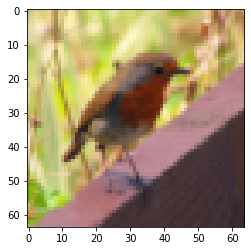

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[:, index]) + ", it's a '" + classes[np.squeeze(train_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


some useful functions

In [7]:
#  sigmoid function

def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    return s


#initialize_with_zeros function

def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b


# propagate function

def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)                                     # compute activation
    cost = -1./m* np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))               # compute cost
    
    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)
   
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


In [8]:
# optimization function

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost =propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

prediction function

In [9]:
# prediction function
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A =   sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

Build the model function

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [11]:
d = model(train_x, train_y, test_x, test_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


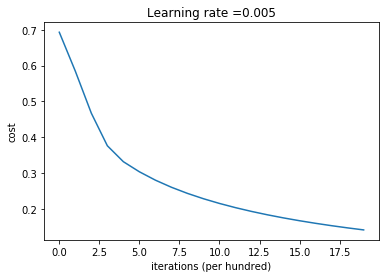

In [12]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundred)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



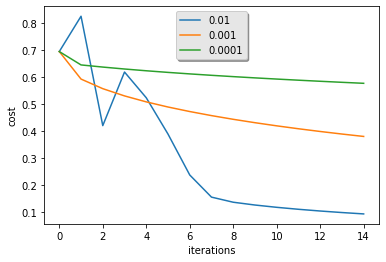

In [13]:
learning_rates = [0.01, 0.001, 0.0001] 
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_x, train_y, test_x, test_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

C:\Users\omprakash\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\omprakash\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


y = 1.0, your algorithm predicts a "cat" picture.


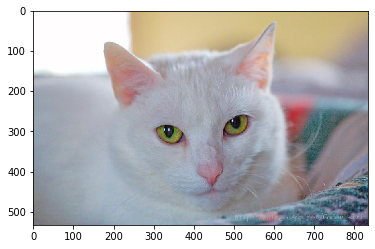

In [14]:
#test the image 
my_image = "E:/deep learning/cat_nonCat/cat3.png"   

image = np.array(ndimage.imread(my_image, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

### Thank You 